# 14.2 NetworkXによる、ソーシャルネットワークの分析
　このレシピでは、Pythonでソーシャルデータを分析する方法を紹介する。ソーシャルデータとは、Facebook、Twitter、Google+、GitHubなどのソーシャルネットワーク上で活動する人々から生成されるデータ。  
　ここではTwitterユーザ間のつながりをNetworkXで分析し、可視化する。

## 準備
　まず、PythonのTwitterパッケージが必要。詳細は、https://pypi.python.org/pypi/twitter を参照。
 ```python
 pip install twitter
 ```
　次にTwitterデータにアクセスするための認証コードを取得する。コードの取得は無料だが、Twitterのアカウントが必要。Twitterの開発者用Webサイトhttps://dev.twitter.com/apps でアプリケーション定義を行うと、このレシピで使用するOAuth認証コードが入手できる。  
　カレントフォルダにテキストファイルtwitter.txtを作成する。4つの認証キーを1行に1つずつ、次の順に4行で書き込む。
- API key
- API secret
- Access token
- Access token secret

　Twitter APIの呼び出しには制限がある。たいていのAPIは、決められた時間内に決められた回数しか呼び出せない。小さなネットワークについて調査したり、大きなネットワークの小さな部分を調べるのであれば、呼び出し回数を調整しなければならない。このレシピでは、APIの制限に抵触しないようにネットワークの小さな部分のみに着目する。そうしなければ、次に時間間隔が始まるため、しばらく待たなければならない。APIの制限については、https://dev.twitter.com/docs/rate-limiting/1.1/limits を参照する。

## 手順
1. 必要なパッケージをインポートする。

In [2]:
import math
import json
import twitter
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image

1. twitter.txtファイルから認証キーを読み込む。

In [7]:
(CONSUMER_KEY,
 CONSUMER_SECRET,
 OAUTH_TOKEN,
 OAUTH_TOKEN_SECRET) = open(
    'twitter.txt', 'r').read().splitlines()

1. Twitter APIへのアクセスを提供するTwitterオブジェクトを作成する。

In [8]:
auth = twitter.oauth.OAuth(OAUTH_TOKEN,
                           OAUTH_TOKEN_SECRET,
                           CONSUMER_KEY,
                           CONSUMER_SECRET)
tw = twitter.Twitter(auth=auth)

1. このレシピではTwitter API1.1を使う。TwitterパッケージではTwitterオブジェクトの属性とREST APIが1対1に対応している。  
ここでは、認証ユーザの識別子を取得するためにacount/verify_credentials RESTリクエストを実行する。

In [9]:
me = tw.account.verify_credentials()

In [10]:
myid = me['id']

1. 指定したユーザ(デフォルトでは、認証ユーザ)のフォロワーIDを返す簡単な関数を定義する。

In [11]:
def get_followers_ids(uid=None):
    # 指定されたユーザのフォロワーIDを取得する
    return tw.followers.ids(user_id=uid)['ids']

In [12]:
# フォロワーをリスト
my_followers_ids = get_followers_ids()

1. つぎに、Twitterユーザのプロファイルを読み出す関数を定義する。users/lookupリクエストは、一定時間内の呼び出し回数に制限がある上に、一度の呼び出しで取得できるプロファイルは100名分に制限されているため、フォロワーの一部だけを扱うことにする。

In [13]:
def get_users_info(users_ids, max=500):
    n = min(max, len(users_ids))
    # 指定ユーザの情報を取得する
    users = [tw.users.lookup(
        user_id=users_ids[100*i:100*(i+1)])
             for i in range(int(math.ceil(n/100.)))]
    # 100名との集合を平たく展開する
    users = [item for sublist in users for item in sublist]
    return {user['id']: user for user in users}

In [14]:
users_info = get_users_info(my_followers_ids)

In [15]:
# 結果をファイルに保存
with open('my_followers.json', 'w') as f:
    json.dump(users_info, f, indent=1)

1. 隣接リスト(技術的には、リストの辞書)を用いたフォロワーのグラフを描画する準備を始める。このグラフは、**エゴグラフ**と呼ばれる。このグラフでえは、フォロワーの持つすべてのフォロー接続が表現される。

In [16]:
adjacency = {myid: my_followers_ids}

1. エゴグラフの中でPythonに関係するものを調べる。特にdescriptionに文字列"Python"を含むフォロワーで、フォロー数が10人分を対象とする。

In [17]:
my_followers_python = [user for user in users_info.values() if 'python' in user['description'].lower()]

In [20]:
my_followers_python_best = sorted(my_followers_python,key=lambda u: u['followers_count'])[::-1][:10]

フォロワーの情報取得には制限があるため、現時点で残り何解字Jっ高できるかを確認する。

In [21]:
tw.application.rate_limit_status(resources='followers') ['resources']['followers']['/followers/ids']

{'limit': 15, 'remaining': 14, 'reset': 1507047147}

In [22]:
for user in my_followers_python_best:
    # get_followers_idsの呼び出しは回数制限がある点に注意
    adjacency[user['id']] = list(set(get_followers_ids(user['id'])).intersection(my_followers_ids))

1. グラフを辞書に格納した隣接リストとして定義し、NetworkXに読み込む。

In [23]:
g = nx.Graph(adjacency)

In [24]:
# プロファイルを取得できるユーザのみにグラフを制限する
g = g.subgraph(users_info.keys())

In [25]:
# グラフもファイルに保存する
with open('my_graph.json', 'w') as f:
    json.dump(nx.to_dict_of_lists(g), f, indent=1)

In [26]:
# 単純化のために、孤立したのノードは取り除く
g.remove_nodes_from([k for k, d in g.degree().items() if d <= 1])

In [27]:
# 自分自身はすべてのノードと接続されているので、簡略化のために自分を取り除くことにする
g.remove_nodes_from([myid])

1. グラフの規模を表示する。

In [29]:
len(g.nodes()), len(g.edges())

(0, 0)

1. グラフ描画を準備する。個々のノードには、フォロワー数とツイート数に従って異なる大きさと色を持たせる。フォロワー数の多いユーザは大きく、ツイート数の多い活発なユーザは濃い赤で表示する。

In [30]:
# 辞書を更新
deg = g.degree()
for user in users_info.values():
    fc = user['followers_count']
    sc = user['statuses_count']
    # Pythonに興味を持つユーザか?
    user['python'] = 'python' in user['description'].lower()
    # ノードの大きさをフォロワー数の関数として計算する
    user['node_size'] = math.sqrt(1 + 10 * fc)
    # ノードの色は、ツイート量から計算する
    user['node_color'] = 10 * math.sqrt(1 + sc)
    # フォロワーの多いユーザの名前を表示する
    user['label'] = user['screen_name'] if fc > 2000 else ''

1. グラフの描画にはdraw()関数を用いる。ノードの大きさのリスト、色のリスト、らベルの辞書を関数に渡す。

In [33]:
node_size = [users_info[uid]['node_size'] for uid in g.nodes()]

In [35]:
node_color = [users_info[uid]['node_color'] for uid in g.nodes()]

In [36]:
labels = {uid: users_info[uid]['label'] for uid in g.nodes()}

/home/ubuntum/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/home/ubuntum/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/home/ubuntum/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/home/ubuntum/anaconda3/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.ho

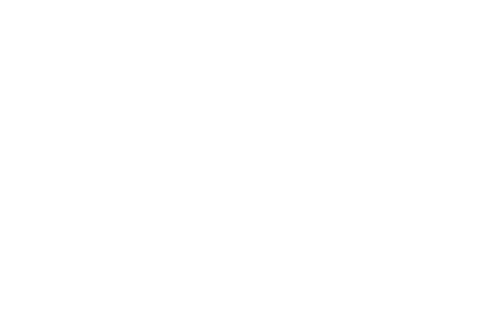

In [37]:
nx.draw(g, cmap=plt.cm.OrRd, alpha=.8, node_size=node_size, node_color=node_color, labels=labels, font_size=4, width=.1)